# Определение успешных компьютерных игр на следующий год 

Для интернет-магазина «Стримчик», который продает компьютерные игры, необходимо найти закономерности которые делают игру успешной. Из вводных данных доступна информация за пошлые года. По ней нужно определить какую рекламу нужно запускать в каком и регионов. И какие игры будут популярны в следующем году

## Общая информация

In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv("/datasets/games.csv")
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Подготовка данных

In [3]:
#Замена названий столбцов
data = data.rename(columns = {'Name':'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score':'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'}, inplace = False)

In [4]:
# Замена типа значения на Int
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['critic_score'] = data['critic_score'].astype('Int64')

In [5]:
print(f'Количество игр: {data.reset_index().name.nunique()}')
print(data['rating'].value_counts())
15/11559

Количество игр: 11559
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64


0.0012976901116013497

In [6]:
# Удаление слишком редких значений. (Они повлияют на конечный результат)
data = data.drop(data[data.rating == 'EC' ].index) 
data = data.drop(data[data.rating == 'RP'].index)
data = data.drop(data[data.rating == 'K-A'].index)
data = data.drop(data[data.rating == 'AO'].index)

In [7]:
data.dropna(subset = ['genre'], inplace = True) # удаление пропусков
data.loc[data['user_score'] == 'tbd', 'user_score'] = None # Замена значения tbd на None
data['user_score'] = data['user_score'].astype('float')

data['critic_score'] = data['critic_score'].fillna(value = -5) # замена пропусщеных значений -5 (потом будет легко найти и исключить)
data['user_score'] = data['user_score'].fillna(value = -5) # замена пропусщеных значений на -5

***Я заменил эти значения на -5 что бы потом было легко их найти и исключить***

***Причины замены данных:***
    
- В столбце genre всего 2 пропуска поэтому мы их удаляем 
- В столбце user score есть значение tbd что значит (будет определена позднее) поэтому заменям на None
    после заменяем все значения None на медиану.
- В столбце user score заменяем все значение None на медиану 

- В столбце rating удаляем выбросы.(игр с таким рейтингом слишком мало)
- Также в столбцах year of release, critic_score и user score меняем тип данных


In [8]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'] # Все продажи
print(data['all_sales'].head(10))

0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
5    30.26
6    29.80
7    28.91
8    28.32
9    28.31
Name: all_sales, dtype: float64


## Исследовательский анализ данных

Text(0.5, 1.0, 'Количество проданных игр по годам')

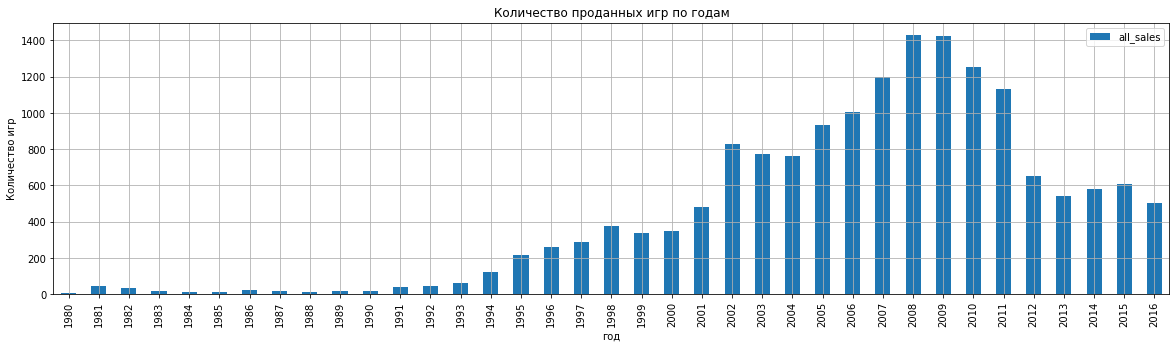

In [9]:
data.pivot_table(index="year_of_release", values="all_sales", aggfunc='count').plot(kind="bar", grid=True, figsize=(20, 5)) # Количество проданных игр по годам
plt.xlabel('год')
plt.ylabel('Количество игр')
plt.title('Количество проданных игр по годам')

***Судя по графику данные после 1994 нам не сильно важны***

In [10]:
# Сортировка Платформ по году релиза игр 
sails_year = data.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
sails_year.fillna(0, inplace=True)


In [11]:
notnull=[] # Пустой список 
#Считаем количество не нулевых значений для каждой приставки по годам.
for platform in sails_year.columns:
    notnull.append(sails_year[platform].ne(0).value_counts().loc[sails_year[platform].ne(0).value_counts().index == True].values[0])
print(notnull)    

'''
Мне кажется это не самое простое решение, Если это так можете подсказать как написать вариант получше.

'''

[10, 2, 6, 7, 11, 13, 8, 7, 5, 1, 7, 12, 4, 26, 1, 10, 12, 11, 4, 12, 6, 6, 2, 10, 1, 3, 11, 5, 12, 9, 4]


'\nМне кажется это не самое простое решение, Если это так можете подсказать как написать вариант получше.\n\n'

In [12]:
notnull = pd.DataFrame(notnull, columns=['seling']) # создаем датафрейм
notnull.describe()  # узнаем медиану

,seling
count,31.000000
mean,7.677419
std,5.081910
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


Text(0.5, 1.0, 'Количество консолей по годам')

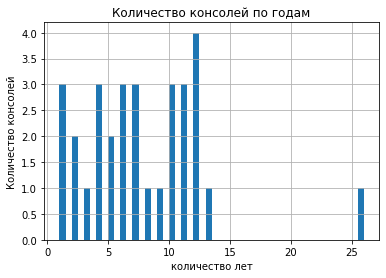

In [13]:
notnull.hist(bins=50) # Гисторамма 
plt.xlabel('количество лет')
plt.ylabel('Количество консолей')
plt.title('Количество консолей по годам')

***Среднее время выпуска игр на консоль около 7 лет.***

In [14]:
# Топ платформ по количеству проданных игр 
top = data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values('all_sales', ascending = False).head(10)
top

,all_sales
platform,
PS2,1255.53
X360,971.42
PS3,939.65
Wii,906.85
DS,805.47
PS,728.95
GBA,317.85
PS4,314.14
PSP,294.05


In [15]:
# Сводная таблица поатформ и проданных игр по годам 
for platform in sails_year.columns:
    if platform not in top.index:
        sails_year.drop(platform, axis=1, inplace=True)
sails_year = sails_year[sails_year.index >= 1994]
sails_year

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1994,0.00,0.00,0.00,6.03,0.00,0.00,0.00,0.00,0.00,0.00
1995,0.00,0.00,0.00,35.96,0.00,0.00,0.00,0.00,0.00,0.00
1996,0.00,0.00,0.00,92.79,0.00,0.00,0.00,0.00,0.00,0.00
1997,0.00,0.00,0.00,136.17,0.00,0.00,0.00,0.00,0.00,0.00
1998,0.00,0.00,0.00,169.49,0.00,0.00,0.00,0.00,0.00,0.00
1999,0.00,0.00,0.00,144.53,0.00,0.00,0.00,0.00,0.00,0.00
2000,0.00,0.00,0.07,96.37,39.17,0.00,0.00,0.00,0.00,0.00
2001,0.00,0.00,61.53,35.59,166.43,0.00,0.00,0.00,0.00,0.00
2002,0.00,0.00,74.16,6.67,205.38,0.00,0.00,0.00,0.00,0.00


Text(0, 0.5, 'Pies Consumed')

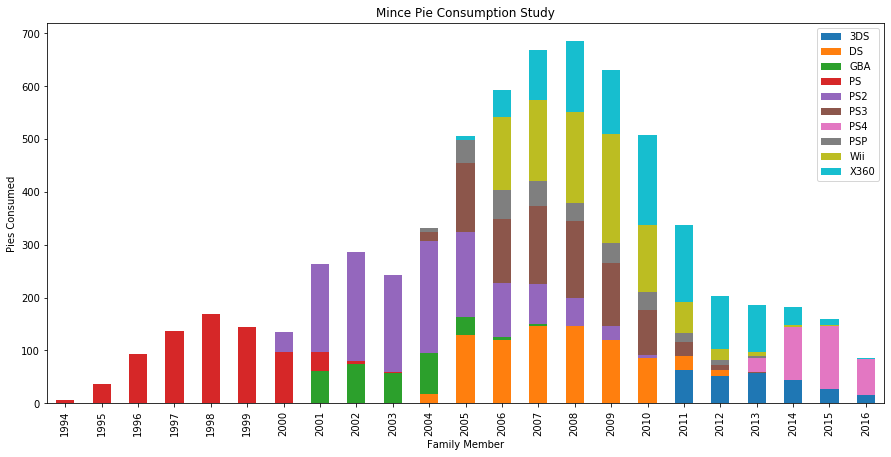

In [16]:
plotdata = pd.DataFrame({
    "3DS":sails_year['3DS'],
    "DS":sails_year['DS'],
    "GBA":sails_year['GBA'],
    "PS":sails_year['PS'],
    "PS2":sails_year['PS2'],
    "PS3":sails_year['PS3'],
    "PS4":sails_year['PS4'],
    "PS3":sails_year['DS'],
    "PSP":sails_year['PSP'],
    "Wii":sails_year['Wii'],
    "X360":sails_year['X360']
    }, 
    index=sails_year.index
)
plotdata.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title("Mince Pie Consumption Study")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

***Консоль на которую будут выпускать игры в 2017 году это PS4. Чтобы в этом убедиться можно взять данные за последние 4 года(так как жизнь консоли обычно 7 лет)***

Text(0, 0.5, 'Pies Consumed')

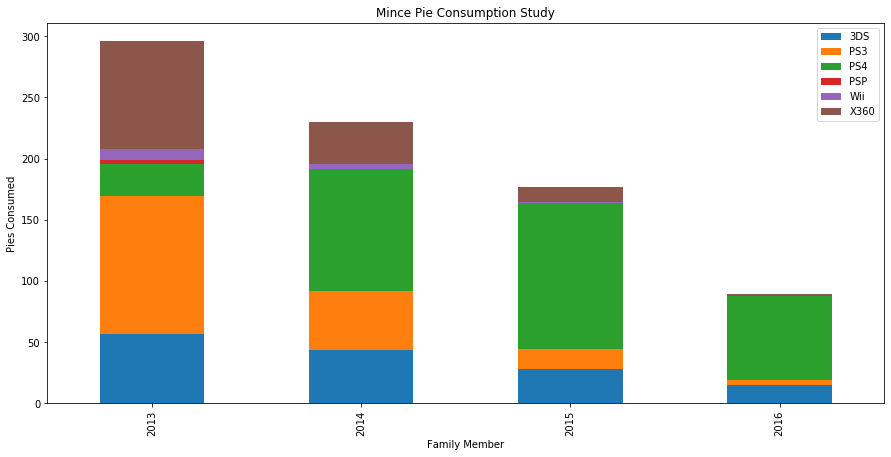

In [17]:
sails_13_17 = sails_year[sails_year.index >= 2013]

plotdata = pd.DataFrame({
    "3DS":sails_13_17['3DS'],
    "PS3":sails_13_17['PS3'],
    "PS4":sails_13_17['PS4'],
    "PSP":sails_13_17['PSP'],
    "Wii":sails_13_17['Wii'],
    "X360":sails_13_17['X360']
    }, 
    index=sails_13_17.index
)
plotdata.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title("Mince Pie Consumption Study")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

***Зная что среднее время выпуска игр на консоль около 7 лет, то по прогнозам на 2017 самая актуальная консоль будет PS4.***
XBOX360, PS3,3DS итд уже исчерпали свой ресурс. Думаю какие, то игры выйдут на 3DS и в 2017, но намного меньше чем на ПС4

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Цены')

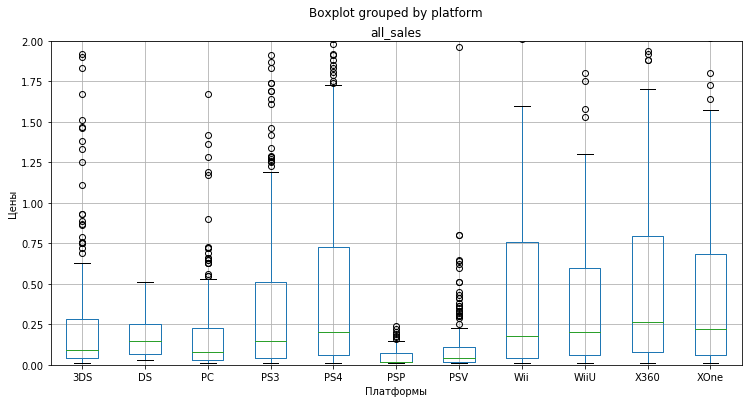

In [18]:
data_new = data[data['year_of_release'] >= 2013]
# Ящик с усами для каждой платформы 
data_new.boxplot(column = 'all_sales', by="platform", figsize=(12, 6))
plt.ylim(0, 2)
plt.xlabel('Платформы')  
plt.ylabel('Цены')

In [19]:
data_new.pivot_table(index="platform", values= 'all_sales', aggfunc='sum')

,all_sales
platform,
3DS,143.25
DS,1.54
PC,39.43
PS3,181.43
PS4,314.14
PSP,3.50
PSV,32.99
Wii,13.66
WiiU,64.63


****Можно сделать вывод что самая прибыльная платформа это PS4, а самая не окупаемая это PSP. Также хорошим спросом пользуются X360, ,PS3, XOne и 3DS.***

In [20]:
ps4 = data_new.query('(platform in "PS4") and (user_score != -5) and (critic_score != -5)') # Только ПС4
ps4


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16486,Super Dungeon Bros,PS4,2016,Action,0.01,0.00,0.00,0.00,42,2.3,E10+,0.01
16499,Sherlock Holmes: The Devil's Daughter,PS4,2016,Adventure,0.01,0.00,0.00,0.00,70,6.8,T,0.01
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69,7.5,NaN,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61,7.9,T,0.01


(0, 20)

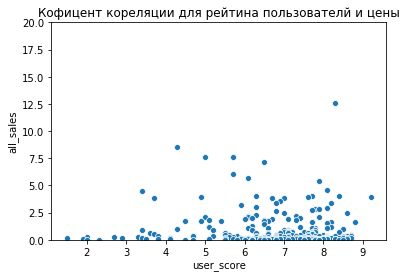

In [21]:
sns.scatterplot(data=ps4, x="user_score", y="all_sales")
plt.title('Кофицент кореляции для рейтина пользователй и цены')
plt.ylim(0, 20)

(0, 20)

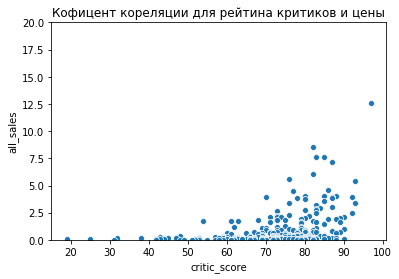

In [22]:
sns.scatterplot(data=ps4, x='critic_score' , y='all_sales')
plt.title('Кофицент кореляции для рейтина критиков и цены')
plt.ylim(0, 20)

На этих графиках на много лучше видно что рейтинг критиков влияет на цену.

In [23]:
ps4.corr() # Кофицент кореляции для ПС4 

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
year_of_release,1.000000,-0.261760,-0.191355,-0.122830,-0.232177,-0.019983,0.150315,-0.234400
na_sales,-0.261760,1.000000,0.714988,0.530480,0.915292,0.414241,-0.022577,0.893807
eu_sales,-0.191355,0.714988,1.000000,0.519826,0.935136,0.346044,-0.050671,0.951656
jp_sales,-0.122830,0.530480,0.519826,1.000000,0.566734,0.322057,0.174512,0.592214
other_sales,-0.232177,0.915292,0.935136,0.566734,1.000000,0.408465,-0.037332,0.997798
critic_score,-0.019983,0.414241,0.346044,0.322057,0.408465,1.000000,0.557654,0.405895
user_score,0.150315,-0.022577,-0.050671,0.174512,-0.037332,0.557654,1.000000,-0.033625
all_sales,-0.234400,0.893807,0.951656,0.592214,0.997798,0.405895,-0.033625,1.000000


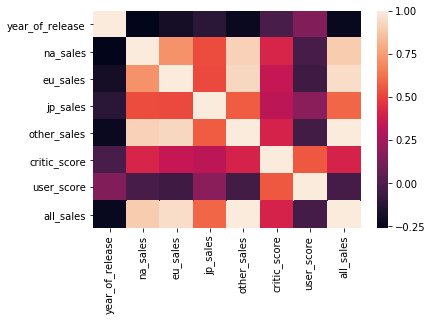

In [24]:
ax = sns.heatmap(ps4.corr())

***Рейтинг пользователей не влияют на количество проданных игр, а отзывы критиков немного, но влияют***
- коэффициенты корреляции -0.06 и 0.34

In [25]:
actual_platforms = ["3DS", "PS3", "WiiU", "X360", "XOne"]
for platform in actual_platforms:
    print(data_new[data_new['platform']== platform].corr())

                 year_of_release  na_sales  eu_sales  jp_sales  other_sales  \
year_of_release         1.000000 -0.075933 -0.115177 -0.063487    -0.083695   
na_sales               -0.075933  1.000000  0.931893  0.641878     0.993708   
eu_sales               -0.115177  0.931893  1.000000  0.633982     0.958274   
jp_sales               -0.063487  0.641878  0.633982  1.000000     0.645306   
other_sales            -0.083695  0.993708  0.958274  0.645306     1.000000   
critic_score            0.005430  0.096662  0.074737 -0.003030     0.093406   
user_score             -0.002700  0.085173  0.070046 -0.035211     0.082845   
all_sales              -0.090086  0.938867  0.927821  0.854173     0.945649   

                 critic_score  user_score  all_sales  
year_of_release      0.005430   -0.002700  -0.090086  
na_sales             0.096662    0.085173   0.938867  
eu_sales             0.074737    0.070046   0.927821  
jp_sales            -0.003030   -0.035211   0.854173  
other_sales  

- critic_score \   user_score
- 0.103681  /  0.065113
- 0.294214  / -0.085058
- 0.331536 /   0.338184
- 0.285467  / -0.044548
- 0.360451 /  -0.105937

***Есть только одна консоль где user_score имеет больший вес чем critic_score это Wii. Мне кажется это можно списать на замену данных. В основном на цену влияют отзывы критиков, и то не очень сильно***

Text(0.5, 1.0, 'Отношение продаж к жанру игры')

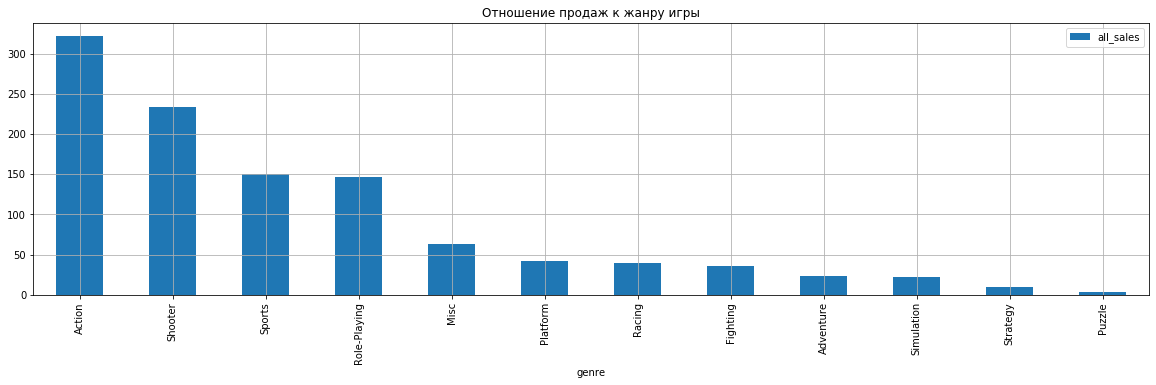

In [26]:
ganre_sales = data_new.pivot_table(index="genre", values= 'all_sales', aggfunc='sum' ).sort_values('all_sales', ascending = False)
ganre_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.title('Отношение продаж к жанру игры')

***Среди продаж по жанрам сразу видны фавориты и аутсайдеры. Экшен игры самые прибыльные, так же от них не сильно отстают шутеры. Самые низкомаржинальный жанр это пазлы.***

In [27]:
data_new.pivot_table(index=['name', 'genre'], values='all_sales', aggfunc='sum').sort_values('all_sales', ascending = False).head(20)

,,all_sales
name,genre,
Grand Theft Auto V,Action,56.58
Call of Duty: Ghosts,Shooter,27.39
Call of Duty: Black Ops 3,Shooter,25.67
Minecraft,Misc,24.16
Call of Duty: Advanced Warfare,Shooter,21.97
FIFA 15,Sports,17.37
FIFA 14,Sports,16.46
FIFA 16,Sports,16.30
Pokemon X/Pokemon Y,Role-Playing,14.60


**Если сортировать игры по самым продаваемым, то в топ 20 будет 1 игра с жанром экшн, и куча шутеров. И майнкрафт к жанру музыки относится -_-**

## Портрет пользователя каждого региона

In [28]:
# Самые популярные платформы по регионам 
na_sales = data_new.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False).head(5)
na_sales_rate = na_sales['na_sales']/ na_sales['na_sales'].sum()
print(na_sales_rate)

eu_sales = data_new.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False).head(5)
eu_sales_rate = eu_sales['eu_sales']/ eu_sales['eu_sales'].sum()
print(eu_sales_rate)

jp_sales = data_new.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False).head(5)
jp_sales_rate = jp_sales['jp_sales']/ jp_sales['jp_sales'].sum()
print(jp_sales_rate)

platform
PS4     0.282280
XOne    0.241732
X360    0.211983
PS3     0.164841
3DS     0.099164
Name: na_sales, dtype: float64
platform
PS4     0.422463
PS3     0.203042
XOne    0.154475
X360    0.127317
3DS     0.092703
Name: eu_sales, dtype: float64
platform
3DS     0.496449
PS3     0.170950
PSV     0.136101
PS4     0.116846
WiiU    0.079654
Name: jp_sales, dtype: float64


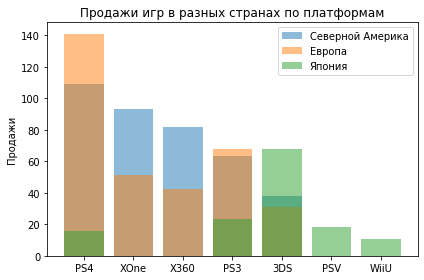

In [29]:
# Все платформы 
all_platforms = []
for i in na_sales.index:
    if i not in all_platforms:
        all_platforms.append(i)
for j in eu_sales.index:
    if j not in all_platforms:
        all_platforms.append(j)
for f in jp_sales.index:
    if f not in all_platforms:
        all_platforms.append(f)


fig, ax = plt.subplots()
rects1 = ax.bar(na_sales.index, na_sales['na_sales'], label='Северной Америка', alpha=0.5)
rects2 = ax.bar(eu_sales.index, eu_sales['eu_sales'], label='Европа', alpha=0.5)
rects2 = ax.bar(jp_sales.index, jp_sales['jp_sales'], label='Япония', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Продажи')
ax.set_title('Продажи игр в разных странах по платформам')
ax.set_xticklabels(all_platforms)
ax.legend()

        

fig.tight_layout()

plt.show()

Text(0.5, 1.0, 'Количество проданных игр по годам')

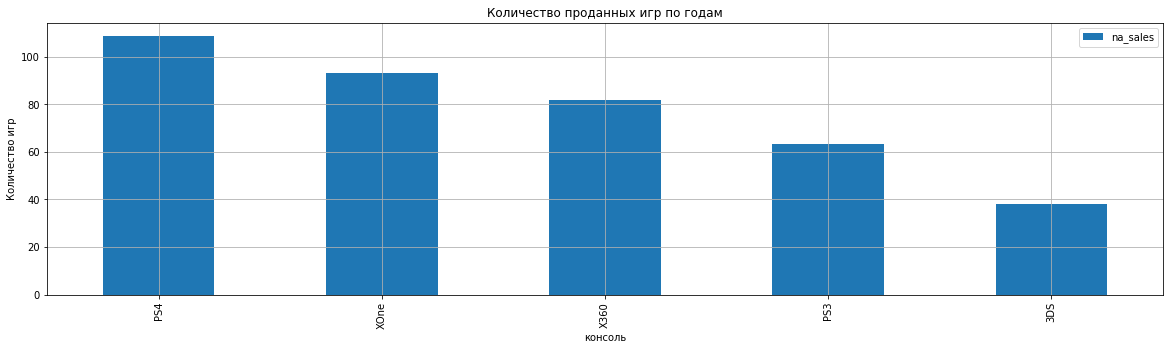

In [30]:
na_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.xlabel('консоль')
plt.ylabel('Количество игр')
plt.title('Количество проданных игр по годам')

Text(0.5, 1.0, 'Количество проданных игр по годам')

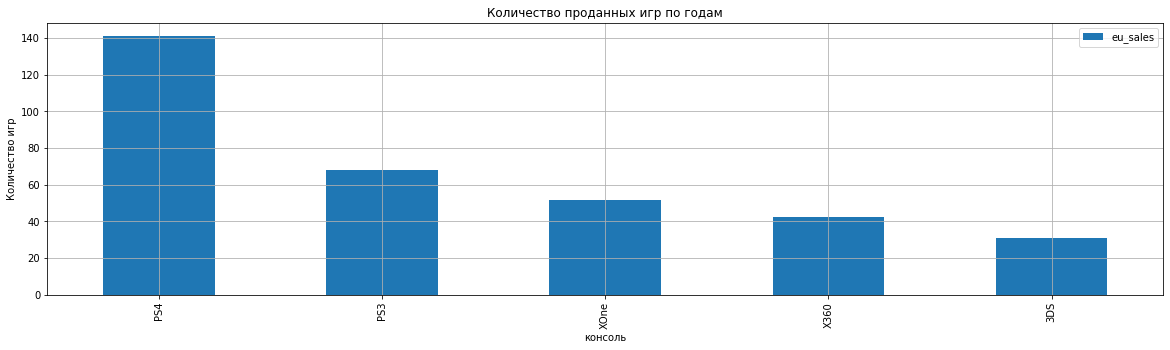

In [31]:
eu_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.xlabel('консоль')
plt.ylabel('Количество игр')
plt.title('Количество проданных игр по годам')

Text(0.5, 1.0, 'Количество проданных игр по годам')

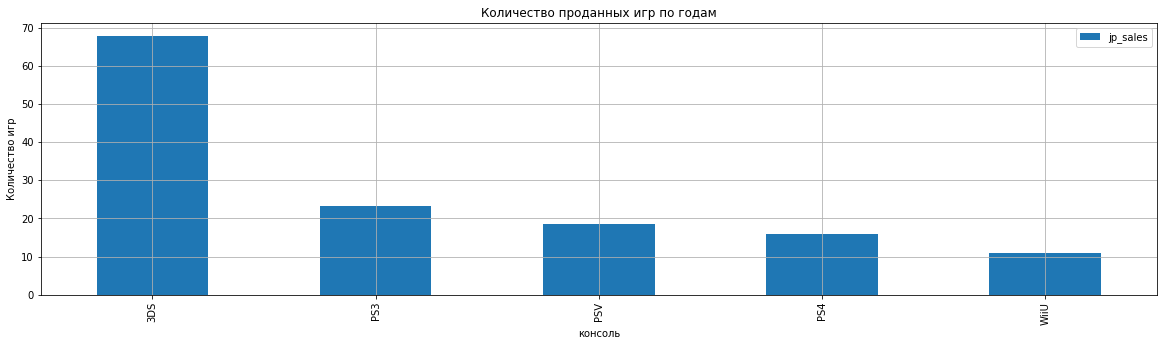

In [32]:
jp_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.xlabel('консоль')
plt.ylabel('Количество игр')
plt.title('Количество проданных игр по годам')

***В случае с Америкой и Европой платформы почти одинаковые, а вот Япония как обычно отличилась. При чем топ 5 в европе и америке содержит одни и те же консоли просто в разном порядке, а в Японии добавляются PSV и WiiU.***


In [33]:
# Самые популярные жанры по регионам 
na_genre = data_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False).head(5)
na_genre_rate = na_genre['na_sales']/ na_genre['na_sales'].sum()
print(na_genre_rate)

eu_genre = data_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False).head(5)
eu_genre_rate = eu_genre['eu_sales']/ eu_genre['eu_sales'].sum()
print(eu_genre_rate)

jp_genre = data_new.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False).head(5)
jp_genre_rate = jp_genre['jp_sales']/ jp_genre['jp_sales'].sum()
print(jp_genre_rate)

genre
Action          0.336178
Shooter         0.292679
Sports          0.174077
Role-Playing    0.123750
Misc            0.073316
Name: na_sales, dtype: float64
genre
Action          0.364970
Shooter         0.271449
Sports          0.186981
Role-Playing    0.114221
Racing          0.062378
Name: eu_sales, dtype: float64
genre
Role-Playing    0.443865
Action          0.352118
Misc            0.080007
Fighting        0.066528
Shooter         0.057483
Name: jp_sales, dtype: float64


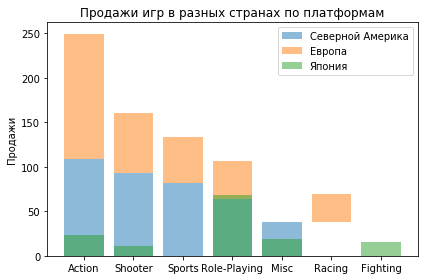

In [34]:
all_platforms = []
for i in na_genre.index:
    if i not in all_platforms:
        all_platforms.append(i)
for j in eu_genre.index:
    if j not in all_platforms:
        all_platforms.append(j)
for f in jp_genre.index:
    if f not in all_platforms:
        all_platforms.append(f)


fig, ax = plt.subplots()
rects1 = ax.bar(na_genre.index, na_sales['na_sales'], label='Северной Америка', alpha=0.5)
rects2 = ax.bar(eu_genre.index, eu_sales['eu_sales'],bottom = na_sales['na_sales'], label='Европа', alpha=0.5)
rects2 = ax.bar(jp_genre.index, jp_sales['jp_sales'], label='Япония', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Продажи')
ax.set_title('Продажи игр в разных странах по платформам')
ax.set_xticklabels(all_platforms)
ax.legend()

        

fig.tight_layout()

plt.show()

***По жанрам тоже похожая ситуация. Хотя Экшены и Шутеры любят все. В Японии очень популярен жанр Role-Playing и Fighting. Возможно поэтому и отличаются платформы. Также Европейцы больше любят музыку, а американцы Гонки.***

In [35]:
data_new['rating'].value_counts()

M       369
T       333
E       302
E10+    252
Name: rating, dtype: int64

- M - **17 years and older**
- T - **13 years and older**
- E - **Kids to Adults**
- E10+ - **aged 10 years and older**

In [36]:
# Самые популярные жанры по регионам 
na_rating = data_new.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False)
na_rating = na_rating['na_sales'] / na_rating['na_sales'].sum()
print(na_rating)
eu_rating = data_new.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False)
eu_rating = eu_rating['eu_sales'] / eu_rating['eu_sales'].sum()
print(eu_rating)
jp_rating = data_new.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False)
jp_rating = jp_rating['jp_sales'] / jp_rating['jp_sales'].sum()
print(jp_rating)

rating
M       0.474346
E       0.226966
E10+    0.155732
T       0.142956
Name: na_sales, dtype: float64
rating
M       0.463807
E       0.266054
E10+    0.136250
T       0.133889
Name: eu_sales, dtype: float64
rating
T       0.369460
E       0.271667
M       0.253185
E10+    0.105688
Name: jp_sales, dtype: float64


***По этому рейтингу можно сделать вывод, что среди Европейских и Американских геймеров самые распространенные это люди 17+, а в Японии это в основном 13+. Хотя по этим данным нельзя выстроить полную картину. 2 место занимает во всех регионах рейтинг Е.Так же рейтинг однозначно влияет на покупку.***

## Проверка гипотез

In [37]:
xone = data_new.query('(platform == "PS4") and (user_score != -5) and (critic_score != -5)')['user_score']
pc = data_new.query('(platform == "PC") and (user_score != -5) and (critic_score != -5)')['user_score']

print(np.var(xone, ddof=1))
print(np.var(pc, ddof=1))


2.119042298225158
2.932444842801986



    Этот параметр 'equal_var' используется когда дисперсии двух выборок различны. Так-же я прочитал статью о том что лучше всега оставлять этот парамтер со значением False. 


In [38]:
alpha = .05

results = st.ttest_ind(
    xone, 
    pc, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00826569237189147
Отвергаем нулевую гипотезу


- ***H0*** - Рейтинги пользователй одинаковые 
- ***Н1*** - Рейтинги пользователй различаются

In [39]:
box_pc = data_new.query('platform in ("XOne", "PC") and (user_score != -5) and (critic_score != -5)')
box_pc.pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,6.302027
XOne,6.538182


- **Гипотезу о том что рейтинг пользователя на обоих платформах одинаковый мы отвергаем.** 
- ***Если посмотреть, то разница довльно большая*** 


In [40]:
action = data_new.query('(genre == "Action") and (user_score != -5) and (critic_score != -5)')['user_score']
sports = data_new.query('(genre == "Sports") and (user_score != -5) and (critic_score != -5)')['user_score']

print(np.var(action, ddof=1))
print(np.var(sports, ddof=1))

1.6462144328163746
2.1316396997497913


In [41]:
alpha = .05

results = st.ttest_ind(
    action, 
    sports, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0496920005008588e-13
Отвергаем нулевую гипотезу


- ***H0*** - Рейтинги пользователй одинаковые 
- ***Н1*** - Рейтинги пользователй различаются

In [42]:
action_sport = data.query('genre in ("Action", "Sports") and (user_score != -5) and (critic_score != -5)')
action_sport.pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,7.093317
Sports,7.105653


- **Гипотезу о том что рейтинг пользователя на обоих платформах одинаковый мы отвергаем.** 
- ***Если посмотреть, то разница довльно большая. Пользователи предпочитают экшен спортивным играм*** 


## Вывод


**Можно сделать вывод о том чтобы продажи шли хорошо нужно продавать игры по этим критериям:**

- Чтобы пользоваться популярностью на европейском или американском рынке игра должна быть разработана для XboxOne и PS4, а вот для японии лучше всего будет игра на 3DS.
- Самый лучший жанр это Экшен. Он подходит всем. Так же для европы и америки популярны шутеры, а для японии role-play.
- Рейтинг ESRB должен быть либо от 17 лет для Америки и Европы или от 13 лет для Японии. Рейтинг Kids to Adults тоже будет хорошим решением так как идет на втором месте во всех странах.

***Думать об оценке пользователей нет смысла. А вот отзывы критиков важны.***

*Портрет пользователя Европы:*
 - Лучшая платформа ПС4 и ПС3 
 - Лучший жанр это Экшен и Шутер 
 - Рейтинг ESRB должен быть: M или Е
 
 *Портрет пользователя Америки:*
 - Лучшая платформа ПС4 и ХboxONE 
 - Лучший жанр это Экшен и Шутер 
 - Рейтинг ESRB должен быть: M или Е
 
 *Портрет пользователя Японии:*
 - Лучшая платформа 3DS и ПС3 
 - Лучший жанр это Role-Playing и Action 
 - Рейтинг ESRB должен быть: Т или Е